<a href="https://colab.research.google.com/github/Eugenescat/15-213/blob/main/term_statistics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Working with Terms and Documents

This exercise starts off with term statistics computations and graphing. In the final section (for CS6200 students), you collect new documents to experiment with.

Read through this Jupyter notebook and fill in the parts marked with `TODO`.

## Sample Data

Start by looking at some sample data. We donwload the counts of terms in documents for the first one million tokens of a newswire collection.

In [4]:
!wget -O ap201001.json.gz https://github.com/dasmiq/cs6200-documents/blob/main/ap201001.json.gz?raw=true
!gunzip ap201001.json.gz

--2025-02-04 21:00:28--  https://github.com/dasmiq/cs6200-documents/blob/main/ap201001.json.gz?raw=true
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/dasmiq/cs6200-documents/raw/refs/heads/main/ap201001.json.gz [following]
--2025-02-04 21:00:28--  https://github.com/dasmiq/cs6200-documents/raw/refs/heads/main/ap201001.json.gz
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dasmiq/cs6200-documents/refs/heads/main/ap201001.json.gz [following]
--2025-02-04 21:00:28--  https://raw.githubusercontent.com/dasmiq/cs6200-documents/refs/heads/main/ap201001.json.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185

We convert this file with one JSON record on each line to a list of dictionaries.

In [5]:
import json
rawfile = open('ap201001.json')
terms = [json.loads(line) for line in rawfile]

Here are the first ten records, showing the count of each term for each document and field. In this dataset, field only takes the values `body` or `title`.

In [6]:
terms[1:10]

[{'id': 'APW_ENG_20100101.0001', 'field': 'body', 'term': 'about', 'count': 1},
 {'id': 'APW_ENG_20100101.0001', 'field': 'body', 'term': 'abuse', 'count': 1},
 {'id': 'APW_ENG_20100101.0001',
  'field': 'body',
  'term': 'academy',
  'count': 1},
 {'id': 'APW_ENG_20100101.0001',
  'field': 'body',
  'term': 'accused',
  'count': 2},
 {'id': 'APW_ENG_20100101.0001',
  'field': 'body',
  'term': 'actress',
  'count': 1},
 {'id': 'APW_ENG_20100101.0001', 'field': 'body', 'term': 'ad', 'count': 1},
 {'id': 'APW_ENG_20100101.0001', 'field': 'body', 'term': 'after', 'count': 1},
 {'id': 'APW_ENG_20100101.0001',
  'field': 'body',
  'term': 'agenda',
  'count': 1},
 {'id': 'APW_ENG_20100101.0001',
  'field': 'body',
  'term': 'agreed',
  'count': 1}]

Each record has four fields:
* `id`, with the identifier for the document;
* `field`, with the region of the document containing a given term;
* `term`, with the lower-cased term; and
* `count`, with the number of times each term occurred in that field and document.

## Computing Term Statistics


If we look at the most frequent terms for a given document, we mostly see common function words, such as `the`, `and`, and `of`. Start exploring the dataset by computing some of these basic term statistics. You can make your life easier using data frame libraries such as `pandas`, core python libraries such as `collections`, or just simple list comprehensions.

Feel free to define helper functions in your code before computing the statistics we're looking for.

In [7]:
# TODO: Print the 10 terms from document APW_ENG_20100101.0001 with the highest count.

from collections import defaultdict

def top_terms_in_document(doc_id, terms, top_k=10):
    term_counts = defaultdict(int)

    for entry in terms:
        if entry['id'] == doc_id:
            term_counts[entry['term']] += entry['count']

    top_terms = sorted(term_counts.items(), key=lambda x: -x[1])[:top_k]

    print(f"Top {top_k} terms in document {doc_id}:")
    for term, count in top_terms:
        print(f"{term}: {count}")

top_terms_in_document("APW_ENG_20100101.0001", terms)


Top 10 terms in document APW_ENG_20100101.0001:
a: 16
the: 11
and: 10
brooks: 10
of: 10
to: 10
he: 9
in: 9
gomez: 8
for: 6


In [8]:
# TODO: Print the 10 terms with the highest total count in the corpus.

def top_terms_in_corpus(terms, top_k=10):
    term_counts = defaultdict(int)

    for entry in terms:
        term_counts[entry['term']] += entry['count']

    top_terms = sorted(term_counts.items(), key=lambda x: -x[1])[:top_k]

    print("Top terms in the corpus:")
    for term, count in top_terms:
        print(f"{term}: {count}")

top_terms_in_corpus(terms)



Top terms in the corpus:
the: 62216
to: 26931
in: 25659
a: 23383
of: 22326
and: 22125
said: 10888
for: 9716
on: 9382
that: 8942


Raw counts may not be the most informative statistic. One common improvement is to use *inverse document frequency*, the inverse of the proportion of documents that contain a given term.

In [9]:
# TODO: Compute the number of distinct documents in the collection.
N = len(set(entry['id'] for entry in terms))

# TODO: Compute the number of distinct documents each term appears in
# and store in a dictionary.
df = defaultdict(set)

for entry in terms:
    df[entry['term']].add(entry['id'])

df = {term: len(docs) for term, docs in df.items()}


In [11]:
# TODO: Print the relative document frequency of 'the',
# i.e., the number of documents that contain 'the' divided by N.

print(f"Relative document frequency of 'the': {df.get('the', 0) / N:.6f}")

Relative document frequency of 'the': 0.970482


Empricially, we usually see better retrieval results if we rescale term frequency (within documents) and inverse document frequency (across documents) with the log function. Let the `tfidf` of term _t_ in document _d_ be:
```
tfidf(t, d) = log(count(t, d) + 1) * log(N / df(t))
```

Later in the course, we will show a probabilistic derivation of this quantity based on smoothing language models.

In [12]:
# TODO: Compute the tf-idf value for each term in each document.
# Take the raw term data and add a tfidf field to each record.
tfidf_terms = None

import math

tfidf_terms = []

for entry in terms:
    term = entry['term']
    doc_id = entry['id']
    count = entry['count']

    if term in df and df[term] > 0:
        tf = math.log(count + 1)
        idf = math.log(N / df[term])
        tfidf_value = tf * idf

        tfidf_entry = entry.copy()
        tfidf_entry['tfidf'] = tfidf_value
        tfidf_terms.append(tfidf_entry)

top_tfidf_terms = sorted(tfidf_terms, key=lambda x: -x['tfidf'])[:20]


In [13]:
# TODO: Print the 20 term-document pairs with the highest tf-idf values.
print("the 20 term-document pairs with the highest tf-idf values:")
for entry in top_tfidf_terms:
    print(f"{entry['id']} - {entry['term']}: {entry['tfidf']:.6f}")

the 20 term-document pairs with the highest tf-idf values:
APW_ENG_20100103.0028 - guarani: 23.292878
APW_ENG_20100105.0061 - nomination: 22.519372
APW_ENG_20100105.0446 - methane: 21.985205
APW_ENG_20100103.0015 - kheire: 21.473448
APW_ENG_20100105.0014 - greyhound: 21.473448
APW_ENG_20100107.0036 - shakespeare: 21.306960
APW_ENG_20100105.0061 - guild: 20.667543
APW_ENG_20100106.0428 - shakespeare: 20.502093
APW_ENG_20100102.0197 - elkhart: 20.338731
APW_ENG_20100106.0075 - magna: 20.338731
APW_ENG_20100106.1325 - sutton: 19.920895
APW_ENG_20100104.0043 - tohti: 19.704034
APW_ENG_20100105.0014 - greyhounds: 19.704034
APW_ENG_20100107.0018 - krewe: 19.704034
APW_ENG_20100107.0928 - minhas: 19.704034
APW_ENG_20100105.0061 - golden: 19.302647
APW_ENG_20100105.0061 - actors: 19.280794
APW_ENG_20100107.0018 - pirate: 19.241530
APW_ENG_20100103.0016 - punk: 19.097114
APW_ENG_20100104.0108 - shiites: 19.014078


## Plotting Term Distributions

Besides frequencies and tf-idf values within documents, it is often helpful to look at the distrubitions of word frequencies in the whole collection. In class, we talk about the Zipf distribution of word rank versus frequency and Heaps' Law relating the number of distinct words to the number of tokens.

We might examine these distributions to see, for instance, if an unexpectedly large number of very rare terms occurs, which might indicate noise added to our data.

In [14]:
# TODO: Compute a list of the distinct words in this collection and sort it in descending order of frequency.
# Thus frequency[0] should contain the word "the" and the count 62216.
term_freq = defaultdict(int)

for entry in terms:
    term_freq[entry['term']] += entry['count']

frequency = sorted(term_freq.items(), key=lambda x: -x[1])

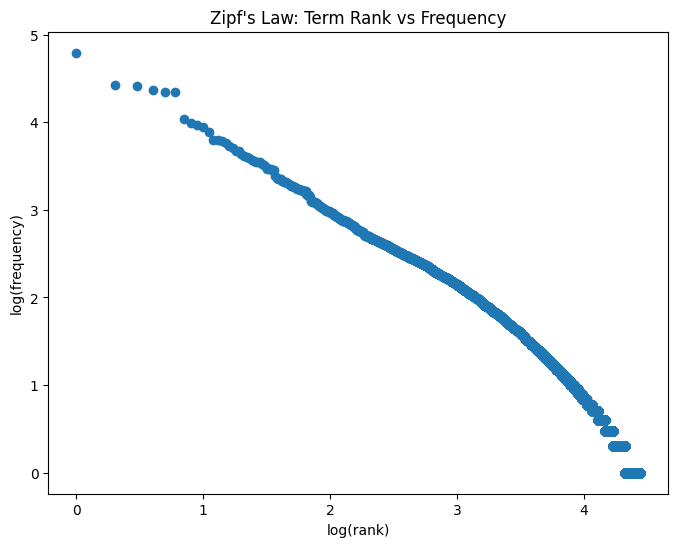

In [15]:
# TODO: Plot a graph of the log of the rank (starting at 1) on the x-axis,
# against the log of the frequency on the y-axis. You may use the matplotlib
# or other library.

import matplotlib.pyplot as plt
import numpy as np

ranks = np.log10(np.arange(1, len(frequency) + 1))
frequencies = np.log10([count for _, count in frequency])

plt.figure(figsize=(8,6))
plt.plot(ranks, frequencies, marker='o', linestyle='none')
plt.xlabel("log(rank)")
plt.ylabel("log(frequency)")
plt.title("Zipf's Law: Term Rank vs Frequency")
plt.show()


In [16]:
# TODO: Compute the number of tokens in the corpus.
# Remember to count each occurrence of each word. For instance, the 62,216
# instances of "the" will all count here.
ntokens = sum(entry['count'] for entry in terms)
print(f"the number of tokens in the corpus: {ntokens}")


the number of tokens in the corpus: 1000000


In [17]:
# TODO: Compute the proportion of tokens made up by the top 10 most
# frequent words.
top_10_words_count = sum(count for _, count in frequency[:10])
print(f"the proportion of tokens made up by the top 10 most frequent words: {top_10_words_count / ntokens:.4f}")


the proportion of tokens made up by the top 10 most frequent words: 0.2216


In [18]:
# TODO: Compute the proportion of tokens made up by the words that occur
# exactly once in this collection.
one_occurrence_count = sum(1 for _, count in frequency if count == 1)
print(f"📌 the proportion of tokens made up by the words that occur exactly once in this collection: {one_occurrence_count / len(frequency):.4f}")

📌 the proportion of tokens made up by the words that occur exactly once in this collection: 0.2410


## Acquiring New Documents (for CS6200)

For this assignment so far, you've worked with data that's already been extracted, tokenized, and counted. In this final section, you'll explore acquiring new data.

One common way of acquiring data is through application programming interfaces (APIs) to various databases. The Library of Congress's [_Chronicling America_](https://chroniclingamerica.loc.gov/) site aggregates digitized US newspapers from the past two hundred years, such as the [_Seattle Star_](https://chroniclingamerica.loc.gov/lccn/sn87093407/1925-01-17/ed-1/seq-1/) from 100 years ago.

You can use [the API](https://chroniclingamerica.loc.gov/about/api/) to retrieve JSON data listing all issues of the _Seattle Star_: https://chroniclingamerica.loc.gov/lccn/sn87093407.json

Note the list in the `issues` field. For example, here is the record for the January 17, 1925, issue: https://chroniclingamerica.loc.gov/lccn/sn87093407/1925-01-17/ed-1.json

In that issue record, you'll see records for each page, e.g.: https://chroniclingamerica.loc.gov/lccn/sn87093407/1925-01-17/ed-1/seq-1.json

And inside that page record, you'll see links to data about that page in various data formats, such as JPEG, PDF, and plain text, which is what we want here: https://chroniclingamerica.loc.gov/lccn/sn87093407/1925-01-17/ed-1/seq-1/ocr.txt

This plain text was transcribed from the old page images using optical character recognition (OCR) models, and so contains errors.

Your task is to acquire and analyze the issues of the _Seattle Star_ from the month of January, 1925, i.e., the issues with a date field that starts with `1925-01`. This should be about the same amount of data as the million words from the Associated Press you analyzed in the last section.

**TODO**: Write code that calls the _Chronicling America_ API to download and extract the text from the _Seattle Star_ from January 1925. You can use the `json` library from above and any other libraries you wish to fetch data from URLs. As you would when working with any production API, you may need to limit your rate of requests.

In [1]:
# TODO: Data acquisition code here.
import requests
import time

# list
url = "https://chroniclingamerica.loc.gov/lccn/sn87093407.json"
response = requests.get(url)

if response.status_code == 200:
    data = response.json()
else:
    print(f"Web Crawling Error: {response.status_code}")
    exit()

# filter by 1925-01
jan_1925_issues = [issue for issue in data["issues"] if issue["date_issued"].startswith("1925-01")]
print(jan_1925_issues)

# retrieve texts
text_data = []
for issue in jan_1925_issues:
    issue_url = issue["url"]
    response = requests.get(issue_url)
    if response.status_code != 200:
        print(f"Web Crawling Error: {response.status_code}")
        exit()
    time.sleep(1)
    pages_info = response.json()["pages"]
    for page_info in pages_info:
        page_url = page_info["url"]
        page_response = requests.get(page_url)

        if page_response.status_code != 200:
          print(f"Web Crawling Error: {response.status_code}")
          exit()
        time.sleep(1)

        text_url = page_response.json()["text"]
        text_response = requests.get(text_url)

        if text_response.status_code != 200:
          print(f"Web Crawling Error: {response.status_code}")
          exit()
        time.sleep(1)

        text = text_response.text
        text_data.append(text)


# combine together
seattle_text = "\n".join(text_data)
print(seattle_text)
print(f"Retrieved {len(jan_1925_issues)} from the Seattle Star from January 1925.")


Web Crawling Error: 429


NameError: name 'data' is not defined

**TODO**: Write code to tokenize the text and count the resulting terms in each document. Since this data comes from automatically transcribing printed pages, some words may be hyphenated across line breaks. There is more than one right way to tokenize this data, so add comments to your code documenting your choices.

In [20]:
# TODO: Tokenization code here.
import re

def tokenize(text):
    words = re.findall(r'\b\w+\b', text.lower())
    return words

seattle_tokens = tokenize(seattle_text)
print(f"Total tokens in Seattle Star from January 1925: {len(seattle_tokens)}")


Total tokens in Seattle Star from January 1925: 47169


**TODO**: Plot a graph of the log rank against log frequency for your collection, as you did for the sample collection above.

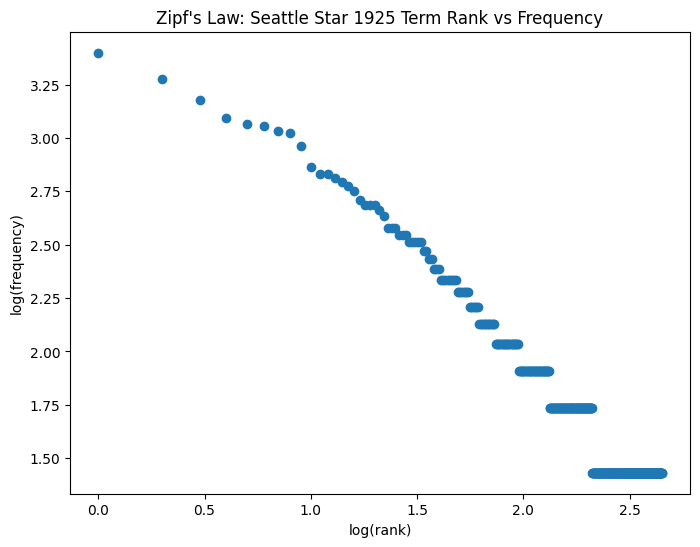

In [21]:
# TODO: Plotting code here.
from collections import Counter

seattle_freq = Counter(seattle_tokens)
seattle_sorted = sorted(seattle_freq.items(), key=lambda x: -x[1])

ranks = np.log10(np.arange(1, len(seattle_sorted) + 1))
frequencies = np.log10([count for _, count in seattle_sorted])

plt.figure(figsize=(8,6))
plt.plot(ranks, frequencies, marker='o', linestyle='none')
plt.xlabel("log(rank)")
plt.ylabel("log(frequency)")
plt.title("Zipf's Law: Seattle Star 1925 Term Rank vs Frequency")
plt.show()


**TODO**: What do you observe about the differences between the distributions of the Associated Press and Seattle Star collections? In this text box, give some possible reasons for these differences.